# TF Single Inequality Constrained Quadratic Optimizing

This notebook demonstrates a single inequality constrained quadratic programming problem solver using TensorFlow.

The approach uses a penalty term in the objective function equation.

## Review

The quadratic programming problem to:

\begin{align}
Minimize      && f(x) = \frac{1}{2} x^t A x + b^{t}x\\
subject\ to   && c_i x + d_i - s_i = 0, && s_i \ge 0\\
&& x \in \mathbb{R}^n, s_i \in \mathbb{R} && \forall i \in I\\
\end{align} 

Putting aside the slack inequalities for the moment
the Lagrangian for the equality constraints is:

$$
L(x,s,\lambda) = f(x) - \sum_{i\in I}\lambda_i(c_ix + d_i - s_i),\space
s_i \ge 0,\space
\lambda_i \ge 0,\space
\forall i \in I
$$

Let $x^*,\lambda^*$ be the solution to the minimization of $L(x,s,\lambda)$.
Create a penalty function of $\mu$ that approaches $L(x,s,\lambda)$ as $\mu \to 0$:

$$
P_{\mu}(x,s,\lambda) = f(x)
- \sum_{i \in I}\lambda_i (c_ix + d_i - s_i)
+ \frac{1}{2\mu}\sum_{i \in I}(c_ix + d_i - s_i)^2
,\space s_i \ge 0
,\space \lambda_i \ge 0
,\space x \in \mathbb{R}^n,\space s_i \in \mathbb{R}
$$

Consider:

$$
\frac{\partial P}{\partial s_i} = \lambda_i - \frac{1}{\mu}(c_ix + d_i - s_i)
$$

When $s_i$ is minimized this partial derivative equals 0. So:

$$
s_{i,\mu} = c_ix + d_i - \mu\lambda_i
$$

Note as $\mu\to 0$ or if $\lambda_i=0$ then $s_i=c_ix + d_i$.
Let $s_\mu^* = (s_{1,\mu}^*, s_{2,\mu}^*, s_{3,\mu}^*, ...)$.
The minimization problem becomes:

$$
Minimize\space
P_{\mu}(x,s_\mu^*,\lambda) = f(x)
- \sum_{i}\lambda_i (c_ix + d_i - s_{i,\mu}^*)
+ \frac{1}{2\mu}\sum_{i}(c_ix + d_i - s_{i,\mu}^*)^2
,\space \lambda_i \ge 0
,\space x \in \mathbb{R}^n
$$

Let $x_{\mu}^*$ be the solution of the minimization of $P_{\mu}(x,s_\mu^*,\lambda)$
and let $\mu_k$ be the kth element of a sequence of $\mu \to 0$.
It can be shown that the sequence of $x_{\mu_k}^* \to x^*$
and that $P_{\mu}(x_{\mu_k}^*,s_\mu^*,\lambda) \to L(x^*,s_\mu^*,\lambda)$.
And it can also be shown that $x_{\mu_k}^*$ is a KKT point for $P_{\mu}(x,s_\mu^*,\lambda)$.
Therefore $\lambda_i$ can be refined with:

$$
\lambda_{i_{k+1}} = \lambda_{i_{k}} - (c_ix + d_i - s_{i,\mu}^*)/u_k,\space\forall i \in I
$$

Let $\lambda_{\mu}^*$ be the limit of the sequence of $\lambda_k =
(\lambda_{1_{k}}, \lambda_{2_{k}}\lambda_{3_{k}}, ...)$.
Since $\lambda_{\mu}^* \to \lambda^*$ and so:

$$
\mathbb{P}(x_{\mu}^*) = P_{\mu}(x_{\mu}^*,s_\mu^*,\lambda_{\mu}^*) \to L(x^*,s^*,\lambda^*)
\space as
\space \mu \to 0
$$

## Algorithm

The general idea of the algorithm is to solve a relaxed penalty function minimization problem that only involves equality constraints. Using the properties of these solution points, tighten the penalty function parameter $\mu$.
It is important to have a good solution, but not necessary an exact solution, to the minimization of $P_\mu$.
On each iteration, update the solution $x_\mu$, the Lagrangian estimates $\lambda_\mu$ and the slack $s_\mu$.
Since ${||\nabla\mathbb{P}(x_{\mu})||}_2 \to 0$ as $x_\mu \to x_\mu^*$, the algorithm will update $\mu$ when
${||\nabla\mathbb{P}(x_{\mu})||}_2 \lt\tau$. Another possibility is that $\mu$ is too relaxed for the constraints.
In this case, $\mu$ will be updated whenever
${||c_ix + d_i - s_{i,\mu}^*||}_2$ $\gt$ $||{\nabla\mathbb{P}(x_{\mu})||}_2$. The constraints norm measures $\nabla_\lambda P_{\mu}$. If the constraints are not being applied strictly enough then $\mu$ needs to be tightened.

## Sample Problem

Consider just one inequality constraint:

\begin{align}
Minimize&& f(x) = \ 2x_1^2 + x_2^2\\
subject\ to&& x_1 + x_2 - s_1 = d\\
and&&s_1 \ge 0
\end{align}

## Preliminaries

In [1]:
from numpy import set_printoptions, array, meshgrid, linspace, sqrt, round as npround, log
import tensorflow as tf

import matplotlib.pyplot as plt

print('tf version: {}'.format(tf.VERSION))
set_printoptions(3)

tf version: 1.7.0


Save the symbolic solution $(x^*,\lambda^*)$ when $d=1$.

In [2]:
xinit = array([ [.8],
                [.8] ])
linit = array([ [1.229] ])
uinit = array([ [1] ])

xstar = array([ [1/3], [2/3] ])
lstar = array([ [4/3] ])
ustar = array([ [+0.118] ])
dstar = array([ [-1] ])

## TensorFlow problem description

Setup the elements of the problem. Note that `x` is the only trainable variable and its initial variable is arbitrary.

In [3]:
def floatvar(name, init, trainable=False):
    return tf.Variable(init, dtype=tf.float32, trainable=trainable, name=name)

A = floatvar("A", [[4, 0],
                   [0, 2] ])

b = floatvar("b", [[0],
                   [0] ])

C = floatvar("C", [ [1, 1] ])

d = floatvar("d", dstar)

l = floatvar("l", linit)

u = floatvar("u", uinit)

x = floatvar("x", xinit, trainable=True)

s = floatvar("s", [ [1] ])

Create the objective function based on the penalty function.

In [4]:
xAx2 = 0.5 * tf.matmul(tf.matmul(tf.transpose(x), A), x)
bx = tf.matmul(tf.transpose(b), x)
fx = xAx2 + bx
Cxd0 = tf.matmul(C, x) + d
Cxd =  Cxd0 - s
lCxd = tf.reshape(tf.reduce_sum(l * Cxd, 0), xAx2.shape)
Cxd2 = tf.matmul(tf.transpose(Cxd), Cxd)
uCxd2 = 0.5 * Cxd2 / u
objective = fx - lCxd + uCxd2

Create the gradient and constraint norm measures.

In [5]:
g_x = tf.gradients(objective, x)[0]
g_x2 = tf.matmul(tf.transpose(g_x), g_x)

gradient = tf.sqrt(g_x2)
constraint = tf.sqrt(Cxd2)

Create the update assignments for $\lambda$, s and $\mu$.

In [6]:
update_l = l.assign(tf.maximum(0., l - Cxd / u))
update_s = s.assign(tf.maximum(0., Cxd0 - u * l))

update_u = u.assign(0.7 * u)

`evaluate` reports objective function information at a given point.

In [7]:
def evaluate(x_, l_, u_):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        _, s_ = sess.run([update_s, s], feed_dict={x: x_, l: l_, u: u_})

        for name, tensor in [
            ('xAx2', xAx2),
            ('bx', bx),
            ('Cxd0', Cxd0),
            ('Cxd', Cxd),
            ('lCxd', lCxd),
            ('Cxd2', Cxd2),
            ('uCxd2', uCxd2),
            ('fx', fx),
            ('objective', objective),
            ('gradient', gradient),
            ('constraint', constraint)
        ]:
            tensor_ = sess.run(tensor, feed_dict={x: x_, l: l_, u: u_, s: s_})
            print('At x:', x_[:,0], 's:', s_[:,0], 'l:', l_[:,0],'u:', u_[:,0],
                  name, tensor_[:,0])

Check objective function values at points of interest.
Note that the constraint error norm and the gradient norm are 0 at $(x^*, \lambda^*)$.

In [8]:
evaluate(x_=xinit, l_=linit, u_=uinit)
evaluate(x_=xstar, l_=lstar, u_=ustar)

At x: [0.8 0.8] s: [0.] l: [1.229] u: [1] xAx2 [1.92]
At x: [0.8 0.8] s: [0.] l: [1.229] u: [1] bx [0.]
At x: [0.8 0.8] s: [0.] l: [1.229] u: [1] Cxd0 [0.6]
At x: [0.8 0.8] s: [0.] l: [1.229] u: [1] Cxd [0.6]
At x: [0.8 0.8] s: [0.] l: [1.229] u: [1] lCxd [0.737]
At x: [0.8 0.8] s: [0.] l: [1.229] u: [1] Cxd2 [0.36]
At x: [0.8 0.8] s: [0.] l: [1.229] u: [1] uCxd2 [0.18]
At x: [0.8 0.8] s: [0.] l: [1.229] u: [1] fx [1.92]
At x: [0.8 0.8] s: [0.] l: [1.229] u: [1] objective [1.363]
At x: [0.8 0.8] s: [0.] l: [1.229] u: [1] gradient [2.748]
At x: [0.8 0.8] s: [0.] l: [1.229] u: [1] constraint [0.6]
At x: [0.333 0.667] s: [0.] l: [1.333] u: [0.118] xAx2 [0.667]
At x: [0.333 0.667] s: [0.] l: [1.333] u: [0.118] bx [0.]
At x: [0.333 0.667] s: [0.] l: [1.333] u: [0.118] Cxd0 [0.]
At x: [0.333 0.667] s: [0.] l: [1.333] u: [0.118] Cxd [0.]
At x: [0.333 0.667] s: [0.] l: [1.333] u: [0.118] lCxd [0.]
At x: [0.333 0.667] s: [0.] l: [1.333] u: [0.118] Cxd2 [0.]
At x: [0.333 0.667] s: [0.] l: [1.333

Utility functions to report on the update.

In [9]:
def fa(a, fmt='{:+6.3f}'):
    return ' '.join([fmt.format(npround(r, 4)) for r in a])

def rep(sess, prefix, i, fd=None):
    x_, s_, l_, u_, g_, c0, c_, o_ = sess.run([
        x, s, l, u, gradient, Cxd0, constraint, objective
    ], feed_dict=fd)

    print(prefix, '{:04d}'.format(i) if i >= 0 else '    ',
          'x:' + fa(x_[:, 0]),
          'l:' + fa(l_[:, 0]),
          's:' + fa(s_[:, 0]),
          'g:' + fa(g_[:, 0]),
          'c:' + fa(c0[:, 0]) + ' ' + fa(c_[:, 0]),
          'u:' + fa(u_[:, 0]),
          'o:' + fa(o_[:, 0]))
    return

`update` runs a single step.
It returns that categorization of minimization step, where 0 is a normal step, and:
1. good solution found for this $\mu$
2. close to solution for this $\mu$
3. constraints need to be tightened

In [10]:
def update(sess, step, tau):
    sess.run(step)
    sess.run(update_l)
    sess.run(update_s)
    g_, c_ = sess.run([gradient, constraint])
    g_, c_ = g_[0,0], c_[0,0]
    
    if c_ > g_:
        return 3
    if g_ < tau:
        return 1
    elif g_ < tau * 2:
        return 2
    return 0

`solve` runs the optimizer, reporting on its progress if enabled and possibly recording the path of the optimization.
Variables are initialized and $d$ is set.
The first line has the $(x^*, \lambda^*)$ result.
The second line has the initial position.
The following lines are coded with the type of report.
The return value always contains the last $x$.
If `path` is set, then it also includes all the intermediate points.

In [11]:
def solve(sess, optimizer, tau, epochs, logmod, path=False, dinit=None):
    tau2 = 2 * tau
    pts = []
    
    if logmod > 0:
        def rep0(sess, prefix, i, update=False, fd=None):
            if update:
                sess.run(update_s, feed_dict=fd)
            rep(sess, prefix, i, fd)
            return
    else:
        def rep0(sess, prefix, i, update=False, fd=None):
            return

    step = optimizer.minimize(objective)

    sess.run(tf.global_variables_initializer())
    
    if dinit != None:
        d.load([ [dinit] ], sess)

    rep0(sess, '*', -1, update=True, fd={x: xstar, l: lstar, u: ustar})
    rep0(sess, 'S', 0, update=True, fd={x: xinit, l: linit, u: uinit})

    sess.run(update_l)
    sess.run(update_s)
        
    for i in range(1, epochs+1):

        flg = update(sess, step, tau2)

        if path:
            x_ = sess.run(x)
            pts.append(x_[:, 0])

        if flg == 3:
            rep0(sess, 'c', i)
            sess.run(update_u)
            rep0(sess, 'C', i)
            continue
        if flg == 2:
            rep0(sess, 'u', i)
            sess.run(update_u)
            rep0(sess, 'U', i)
            continue
        if flg == 1:
            rep0(sess, 'T', i)
            break
        if logmod > 0 and i % logmod == 0:
            rep0(sess, 'i', i)

    rep0(sess, 'F', i)
    if  path == False:
        x_ = sess.run(x)
        pts.append(x_[:, 0])

    return array(pts)

Run an optimization

In [12]:
with tf.Session() as sess:
    solve(sess, tf.train.GradientDescentOptimizer(0.01), tau=0.01, epochs=250, logmod=10)

*      x:+0.333 +0.667 l:+1.333 s:+0.000 g:+0.000 c:+0.000 +0.000 u:+0.118 o:+0.667
S 0000 x:+0.800 +0.800 l:+1.229 s:+0.000 g:+2.748 c:+0.600 +0.600 u:+1.000 o:+1.363
i 0010 x:+0.532 +0.654 l:+0.036 s:+0.150 g:+2.498 c:+0.186 +0.036 u:+1.000 o:+0.993
i 0020 x:+0.360 +0.540 l:+0.303 s:+0.000 g:+1.237 c:-0.100 +0.100 u:+1.000 o:+0.586
i 0030 x:+0.333 +0.541 l:+1.707 s:+0.000 g:+0.904 c:-0.126 +0.126 u:+1.000 o:+0.738
i 0040 x:+0.397 +0.634 l:+2.126 s:+0.000 g:+0.971 c:+0.031 +0.031 u:+1.000 o:+0.652
i 0050 x:+0.408 +0.677 l:+1.370 s:+0.000 g:+0.356 c:+0.085 +0.085 u:+1.000 o:+0.679
i 0060 x:+0.357 +0.647 l:+0.912 s:+0.000 g:+0.650 c:+0.005 +0.005 u:+1.000 o:+0.670
c 0070 x:+0.326 +0.625 l:+1.237 s:+0.000 g:+0.041 c:-0.049 +0.049 u:+1.000 o:+0.665
C 0070 x:+0.326 +0.625 l:+1.237 s:+0.000 g:+0.057 c:-0.049 +0.049 u:+0.700 o:+0.665
i 0080 x:+0.346 +0.651 l:+1.648 s:+0.000 g:+0.438 c:-0.002 +0.002 u:+0.700 o:+0.668
i 0090 x:+0.357 +0.671 l:+1.354 s:+0.000 g:+0.116 c:+0.028 +0.028 u:+0.700 o

In [13]:
with tf.Session() as sess:
    solve(sess, tf.train.GradientDescentOptimizer(0.01), tau=0.01, epochs=250, logmod=10, dinit=-0.5)

*      x:+0.333 +0.667 l:+1.333 s:+0.343 g:+1.886 c:+0.500 +0.157 u:+0.118 o:+0.562
S 0000 x:+0.800 +0.800 l:+1.229 s:+0.000 g:+3.405 c:+1.100 +1.100 u:+1.000 o:+1.173
i 0010 x:+0.532 +0.654 l:+0.036 s:+0.650 g:+2.497 c:+0.686 +0.036 u:+1.000 o:+0.992
i 0020 x:+0.354 +0.534 l:+0.026 s:+0.362 g:+1.772 c:+0.388 +0.026 u:+1.000 o:+0.535
i 0030 x:+0.235 +0.436 l:+0.019 s:+0.153 g:+1.283 c:+0.171 +0.019 u:+1.000 o:+0.301
i 0040 x:+0.156 +0.357 l:+0.014 s:+0.000 g:+0.947 c:+0.013 +0.013 u:+1.000 o:+0.176
i 0050 x:+0.120 +0.309 l:+0.451 s:+0.000 g:+0.103 c:-0.071 +0.071 u:+1.000 o:+0.159
i 0060 x:+0.148 +0.326 l:+0.990 s:+0.000 g:+0.559 c:-0.026 +0.026 u:+1.000 o:+0.176
i 0070 x:+0.180 +0.355 l:+0.868 s:+0.000 g:+0.165 c:+0.036 +0.036 u:+1.000 o:+0.161
c 0073 x:+0.182 +0.358 l:+0.751 s:+0.000 g:+0.018 c:+0.040 +0.040 u:+1.000 o:+0.165
C 0073 x:+0.182 +0.358 l:+0.751 s:+0.000 g:+0.041 c:+0.040 +0.040 u:+0.700 o:+0.166
i 0080 x:+0.171 +0.347 l:+0.449 s:+0.000 g:+0.374 c:+0.018 +0.018 u:+0.700 o

## Plot the iterative process

Make a plot of the path that various optimizers use to get to the minimum.
Show the change in the objective function by displaying a contour map of
the initial configuration and another with the $x^*$ configuration.
The contours are made by evaluating the objective function on a grid of points.
Use `zvalues` to evaluate the objective at these points.
Mark the estimated $x^*$ using the minimum of the objective function on the grid points.

Now, for each optimizer build an objective function solver.
Run the algorithm and record the path of $x$ values.
Earlier parts of the path are more transparent.
Include $x^*$ marking the numeric solution using the last optimizer in the list.

In [14]:
def pathplot(opts, sz=8, epochs=500, samples=41, contours=15, lohi=[0, 1], dinit=None):
    
    grid = meshgrid(linspace(lohi[0], lohi[1], samples),
                    linspace(lohi[0], lohi[1], samples))
    
    def zvalues(sess, lambdas, mu):
        z = []
        m = None
        mv = 0
        sess.run(tf.global_variables_initializer())
        if dinit != None:
            d.load([ [dinit] ], sess)
        for row in range(samples):
            gxrow, gyrow = grid[0][row], grid[1][row]
            r = []
            for col in range(samples):
                gx = gxrow[col]
                gy = gyrow[col]
                sess.run(update_s, feed_dict={x: [[gx], [gy]], l: lambdas, u: mu})
                obj_ = sess.run(objective, feed_dict={x: [[gx], [gy]], l: lambdas, u: mu})
                if m == None or obj_ < mv:
                    mv = obj_
                    m = [row, col]
                r.append(obj_[0, 0])
            z.append(r)
        return array(z), m

    plt.figure(figsize=(sz, sz))
    cmap = plt.get_cmap('inferno')
    if len(opts) > 1:
        colors = [cmap(i) for i in linspace(1, 0, len(opts))]
    else:
        colors = [cmap(0)]
    
    with tf.Session() as sess:
        z, m = zvalues(sess, linit, uinit)
        plt.contour(grid[0], grid[1], z, contours,
                    alpha=0.25, linestyles='dashed', colors='k')
        plt.plot(grid[0][m[0]][m[1]], grid[1][m[0]][m[1]], 'o', c='k', alpha=0.5, mfc='none',
                 label='x0*')
        
        o = 0
        for optimizer in opts:
            clr = colors[o]
            o += 1
            pts = solve(sess, optimizer, tau=0.01, epochs=epochs, logmod=0, path=True, dinit=dinit)
            x_, l_, c_, s_, u_, o_ = sess.run([x, l, Cxd0, s, u, objective])
            lbl = '{:04d} {:s} {:s} {:s} {:s} {:s} {:s} {:s}'.format(
                len(pts),
                fa(x_[:,0], fmt='{:+4.2f}'),
                fa(l_[:,0], fmt='{:+4.2f}'),
                fa(c_[:,0], fmt='{:+4.2f}'),
                fa(s_[:,0], fmt='{:+4.2f}'),
                fa(u_[:,0], fmt='{:+4.2f}'),
                fa(o_[:,0], fmt='{:+4.2f}'),
                optimizer.get_name())
            
            tenth = len(pts) // 10
            if tenth < 2:
                plt.plot(pts[:, 0], pts[:, 1], color=clr, label=lbl)
            else:
                lr = 0
                for i in range(10):
                    r = tenth * (i+1)
                    if r >= len(pts):
                        r = len(pts-1)
                    if i == 9:
                        plt.plot(pts[lr:r, 0], pts[lr:r, 1], alpha=0.1*(i+1), color=clr, label=lbl)
                    else:
                        plt.plot(pts[lr:r, 0], pts[lr:r, 1], alpha=0.1*(i+1), color=clr)
                    lr = r-1

        z, m = zvalues(sess, l_, u_)
        r = plt.contour(grid[0], grid[1], z, contours,
                    alpha=0.25, linestyles='dashed', colors='b')
        plt.clabel(r, inline=1, fontsize=10)
        plt.plot(grid[0][m[0]][m[1]], grid[1][m[0]][m[1]], 'o', c='b', alpha=0.5, mfc='none',
                label='~x* ' + fa([ z[m[0]][m[1]] ]))

        plt.plot(pts[-1, 0], pts[-1, 1], 'o', c='b', mfc='none',
                label='x* ' + fa(o_[:,0]))
        
        d_ = sess.run(d)
        d_ = -d_[0,0]
    
    plt.plot([0, d_], [d_, 0], ls=':', c='k',
            label='Constraint 1: x l c s u o name')

    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.title('\n'.join(['Optimizer Paths overlayed on contour plot with:',
                         '$\lambda$: 0 in black, * in blue'
                        ]))
    plt.show()
    return

Make a list of optimizers with reasonable parameters.

In [15]:
optimizers = [
    tf.train.RMSPropOptimizer(0.01),
    tf.train.MomentumOptimizer(0.01, 0.02),
    tf.train.AdadeltaOptimizer(10),
    tf.train.AdagradOptimizer(0.5),
    tf.train.AdamOptimizer(0.01),
    tf.train.GradientDescentOptimizer(0.01)
]

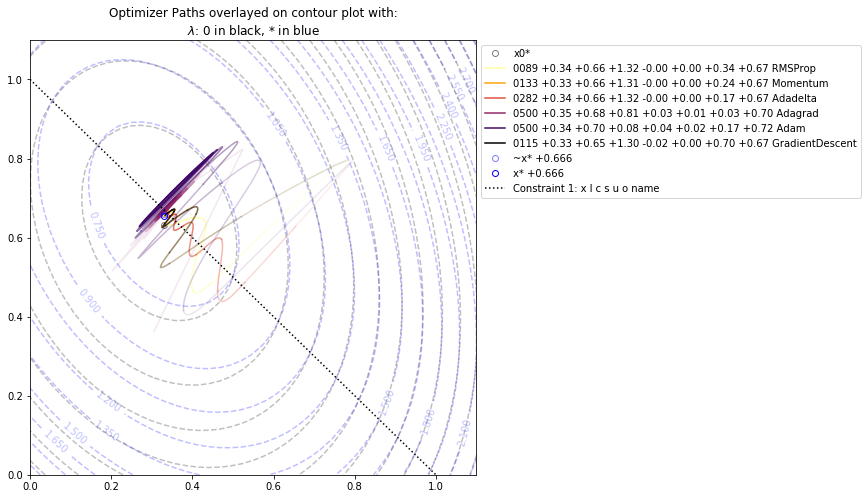

In [16]:
pathplot(optimizers, lohi=[0,1.1])

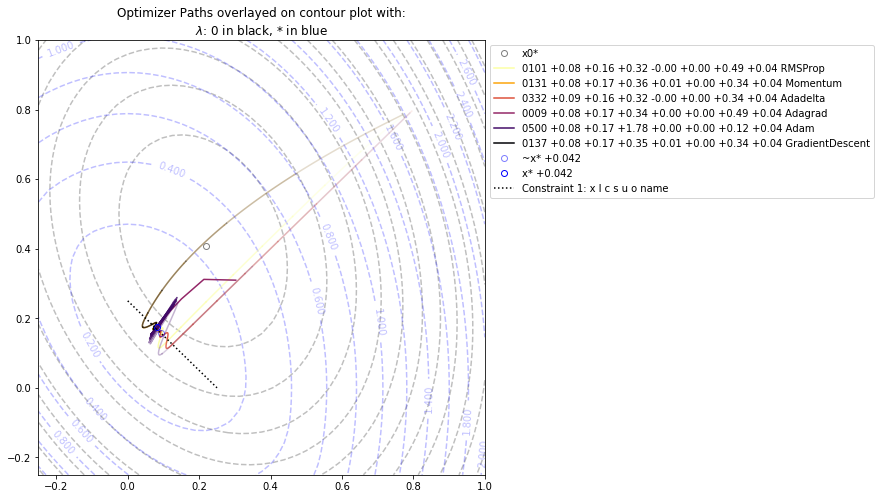

In [17]:
pathplot(optimizers, dinit=-0.25, lohi=[-.25,1])

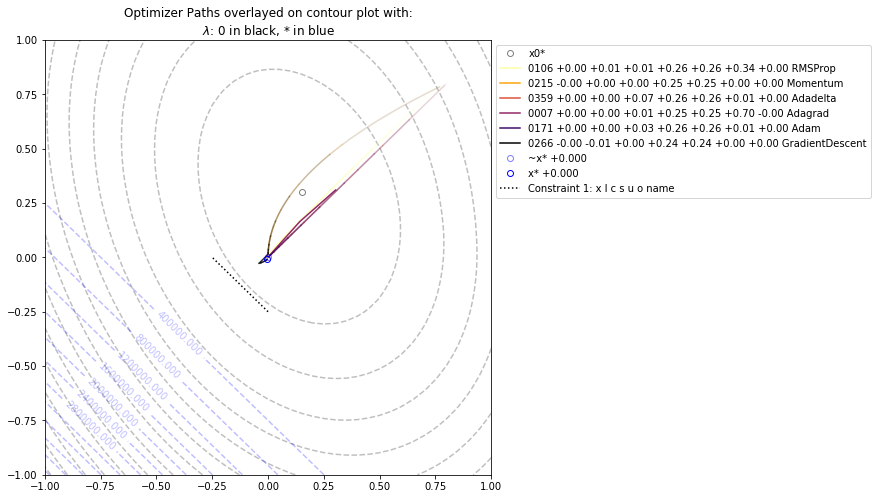

In [18]:
pathplot(optimizers, dinit=0.25, lohi=[-1,1])

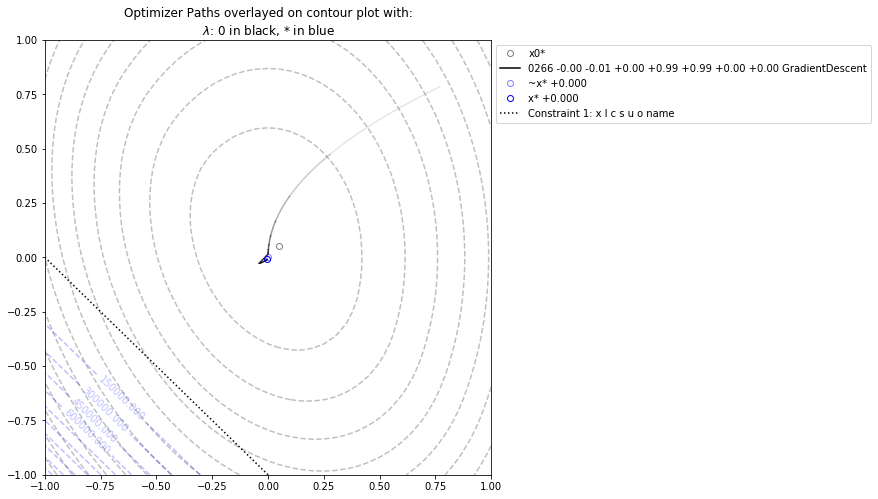

In [19]:
pathplot([optimizers[-1]], dinit=1, lohi=[-1,1])

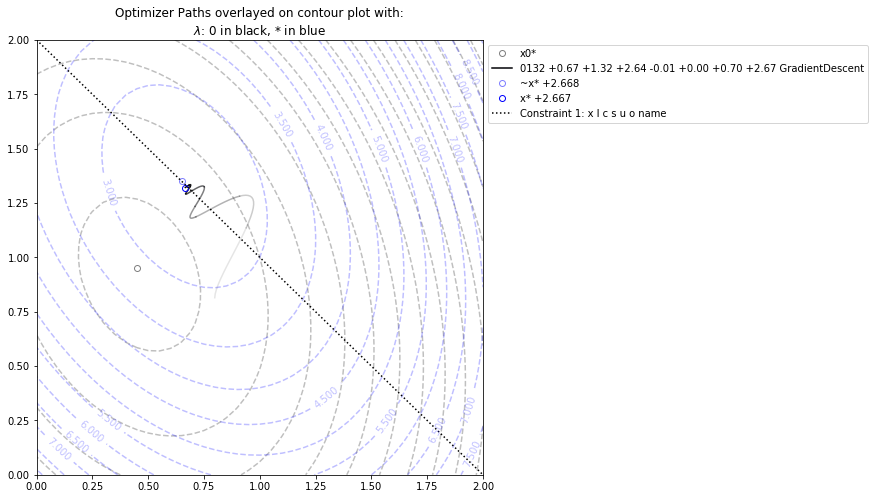

In [20]:
pathplot([optimizers[-1]], dinit=-2, lohi=[0,2])

## References

* [Numerical Optimization, Nocedal & Wright, 2006](http://www.bioinfo.org.cn/~wangchao/maa/Numerical_Optimization.pdf)
* ["Introduction TensorFlow - Optimization of Objective Functions", Wieschollek, 2017](http://patwie.com/tutorials/tensorflow-optimization.html)
* [Constrained linear regression using Tensorflow](https://nipunbatra.github.io/blog/2017/nn-linear-regression-tensorflow.html)
